# Tutorial: Calculating liquefaction probabilities from a single earthquake

The OpenQuake engine now has several models for calculating the probabilities of liquefaction and the displacements from liquefaction-induced lateral spreading given the magnitude of an earthquake, the Peak Ground Acceleration (PGA) at each site, and the susceptibility of each site to liquefaction (which is based on local geotechnical characteristics and a soil wetness variable or proxy).

These functions are quite easy to use and the calculations are very rapid.

Functionality for calculating these probabilities and displacements given a large number of earthquakes is being implemented in the OpenQuake engine. However, the functions below are easily incorporated into a script that can iterate over the results of an event-based PSHA, though this will not be demonstrated here.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from openquake.sep.liquefaction import (
    zhu_etal_2015_liquefaction_probability_general,
    hazus_liquefaction_probability
)

from openquake.sep.liquefaction.lateral_spreading import (
    hazus_lateral_spreading_displacement
)

In [2]:
sites = pd.read_csv("./tutorial_data/liquefaction_sites.csv")

sites.head()

,lon,lat,unit,susc_cat,gwd,vs30,cti
0,-76.540896,3.350158,TQplp,n,3.0,425.0,4.287466
1,-76.544763,3.350644,TQplp,n,3.0,425.0,3.614118
2,-76.528079,3.346550,TQplp,n,3.0,425.0,5.328922
3,-76.529860,3.356627,TQplp,n,3.0,425.0,6.514543
4,-76.527918,3.351601,TQplp,n,3.0,425.0,6.139852


In [3]:
event_mag = 7.2

event_pga = pd.read_csv("./tutorial_data/example_pga.csv")

event_pga.head()

,lon,lat,pga
0,-76.540896,3.350158,0.321998
1,-76.544763,3.350644,0.390889
2,-76.528079,3.346550,0.378206
3,-76.529860,3.356627,0.410492
4,-76.527918,3.351601,0.287797


## Liquefaction probabilities using the HAZUS model

The HAZUS model calculates the probabilities of liquefaction given the magnitude and PGA of an earthquake, the liquefaction category of the site, and the depth to groundwater at that site.

In [4]:
hazus_liq_prob = hazus_liquefaction_probability(pga=event_pga["pga"], mag=event_mag,
                                                liq_susc_cat=sites["susc_cat"],
                                                groundwater_depth=sites["gwd"])

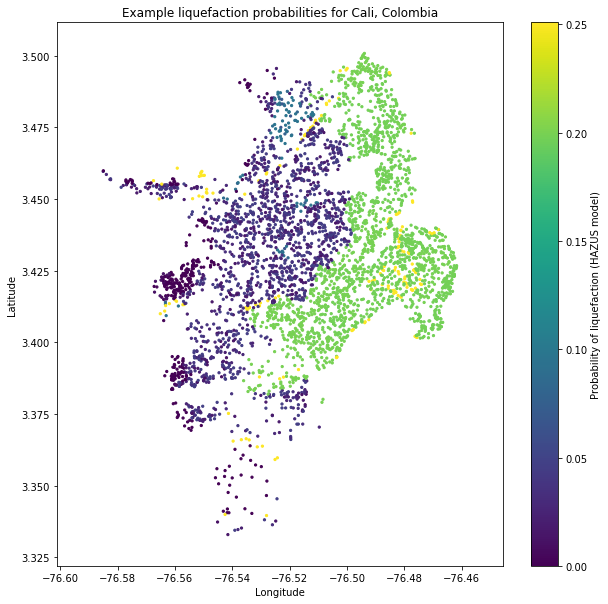

In [5]:
plt.figure(figsize=(10,10))


plt.axis('equal')

plt.scatter(sites.lon, sites.lat, s=5, c=hazus_liq_prob)

plt.colorbar(label='Probability of liquefaction (HAZUS model)')

plt.title('Example liquefaction probabilities for Cali, Colombia')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

## Liquefaction probabilities using the model from Zhu et al. (2015)

The liquefaction probability model by Zhu et al (2015) is based on a multivariate logistic regression. The dependent variables are the magnitude and PGA from an earthquake, and the Vs30 and Compound topographic Index (CTI) at each site.

In [6]:
zhu_liq_prob = zhu_etal_2015_liquefaction_probability_general(pga=event_pga["pga"], mag=event_mag, 
                                                    cti=sites["cti"], vs30=sites["vs30"])

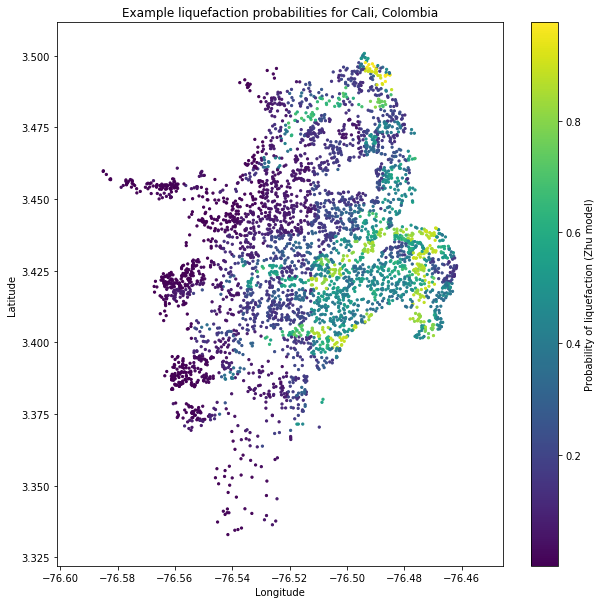

In [7]:
plt.figure(figsize=(10,10))

plt.axis('equal')

plt.scatter(sites.lon, sites.lat, s=5, c=zhu_liq_prob)

plt.colorbar(label='Probability of liquefaction (Zhu model)')

plt.title('Example liquefaction probabilities for Cali, Colombia')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

## Comparison

The liquefaction models here are based on different types of data and were developed quite intependently. It is instructive to compare them.

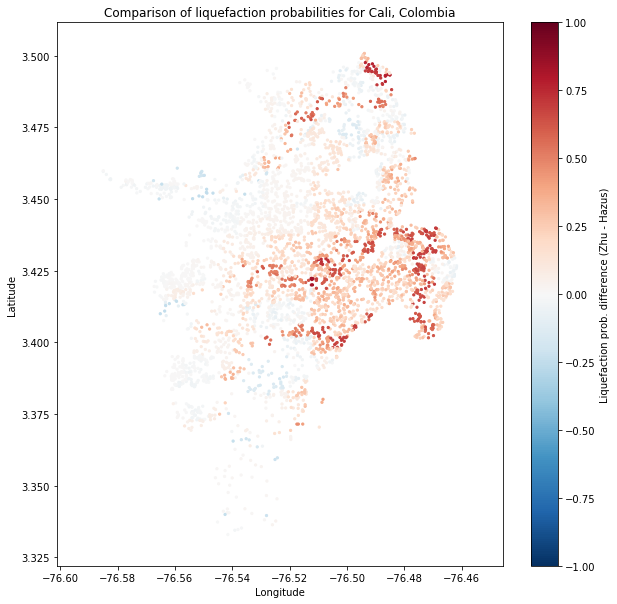

In [8]:
plt.figure(figsize=(10,10))

plt.axis('equal')

plt.scatter(sites.lon, sites.lat, s=5, 
            c=zhu_liq_prob-hazus_liq_prob,
            vmin=-1., vmax=1.,
            cmap='RdBu_r')

plt.colorbar(label='Liquefaction prob. difference (Zhu - Hazus)')

plt.title('Comparison of liquefaction probabilities for Cali, Colombia')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

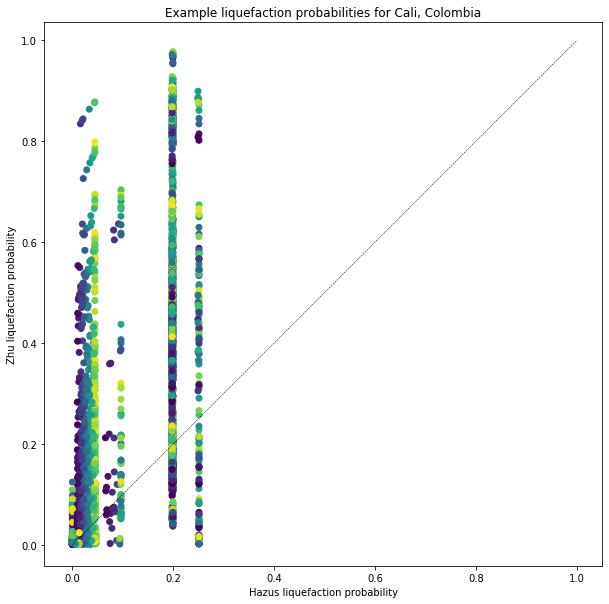

In [9]:
plt.figure(figsize=(10,10))

plt.axis('equal')
plt.scatter(hazus_liq_prob, zhu_liq_prob, c=event_pga["pga"])

plt.plot([0,1],[0,1], 'k--', lw=0.5)

plt.title('Example liquefaction probabilities for Cali, Colombia')
plt.xlabel('Hazus liquefaction probability')
plt.ylabel('Zhu liquefaction probability')


plt.show()

It is clear from these plots that the two liquefaction models produce highly discrepant results.  This is a warning that they should be implemented with caution, and calibrated on a local to regional level if at all possible.  Both models may be calibrated by adjusting the coefficents for each variable relating soil strength and wetness to liquefaction. 

Unfortunately, the tools for these calibrations are not implemented in the MBTK, although the functions used internally in the MBTK may accept modified coefficients.

## Lateral spreading displacements

Displacements due to lateral spreading associated with liquefaction can be calculated given the earthquake's PGA, magnitude, and the liquefaction susceptibility of each site. The model currently implemented is from HAZUS.

In [10]:
hazus_displacements = hazus_lateral_spreading_displacement(event_mag, event_pga["pga"], sites["susc_cat"])

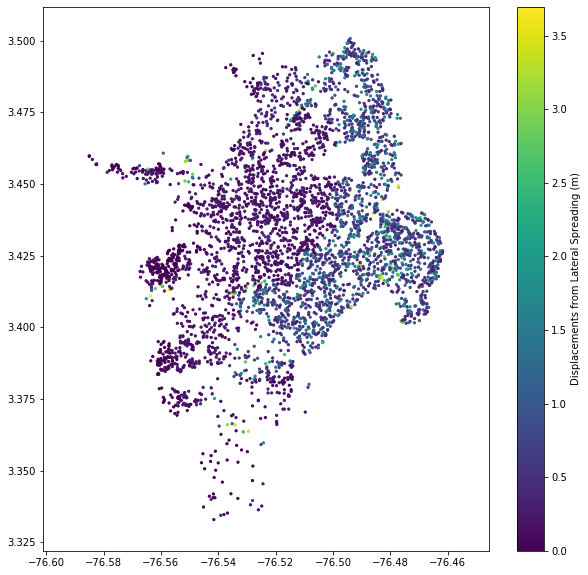

In [11]:
plt.figure(figsize=(10,10))
plt.axis('equal')

plt.scatter(sites.lon, sites.lat, s=5, 
            c=hazus_displacements,
            )

plt.colorbar(label='Displacements from Lateral Spreading (m)')

plt.show()